In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload

import datetime as dt
os.chdir("../from_config") ######!!!!!!
import dev.submit_testdata as dl
graph_data=dl.graph_data

Notebook
GPU detected
Not notebook


In [8]:
os.chdir('../model_eval')
os.getcwd()

'/lustre/hpc/hep/chri862z/work/IceCube/model_eval'

In [2]:
with tf.device('/cpu:0'):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model=tf.keras.models.load_model("trained_models/IceCube_neutrino/KHop_K[1,2]agmaxn_25_2htf2yxw", options=save_options)
model.compile()
batch_size=512
# dataset=graph_data(test_steps=10, n_neighbors=25, restart=False, \
#                                      transform_path='../db_files/dev_lvl7//transformers.pkl')
# loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [3]:
@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets

NameError: name 'loader' is not defined

In [ ]:
def predict(loader):
    prediction_list, target_list = [], []
    for batch in tqdm(loader):
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)

        prediction_list.append(predictions.numpy())
        target_list.append(targets.numpy())
        y_reco  = tf.concat(prediction_list, axis = 0).numpy()
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32).numpy()
    return y_reco, y_true

In [14]:
loader = DisjointLoader(dataset[:int(1e5)], batch_size=batch_size, epochs=1)
reco, true=predict(loader)

In [80]:
from scipy.special import iv
ze_sigma = np.sqrt(1 - iv(1,np.square(reco[:,3]))/iv(0,np.square(reco[:,3])))*180/np.pi
az_sigma = np.sqrt(1 - iv(1,np.square(reco[:,4]))/iv(0,np.square(reco[:,4]))*180/np.pi

In [88]:
zenimask=reco[:,3]>np.median(reco[:,3])
azimask=reco[:,4]>np.median(reco[:,4])

In [89]:
zenireco, zenitrue=reco[zenimask], true[zenimask]
azireco, azitrue=reco[azimask], true[azimask]

In [90]:
mask=np.logical_and(zenimask, azimask) 
reco1, true1=reco[mask], true[mask]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


{'Old metrics:': ' ', 'E': 0.644, 'Omega': '110.234', 'Zeni': '48.868', 'Azi': '100.063'} {'E': '0.437, 0.130<->0.918', 'Omega': '88.778, 46.015<->132.178', 'Zeni': '33.311, 10.132<->67.869', 'Azi': '68.918, 19.959<->134.240'}


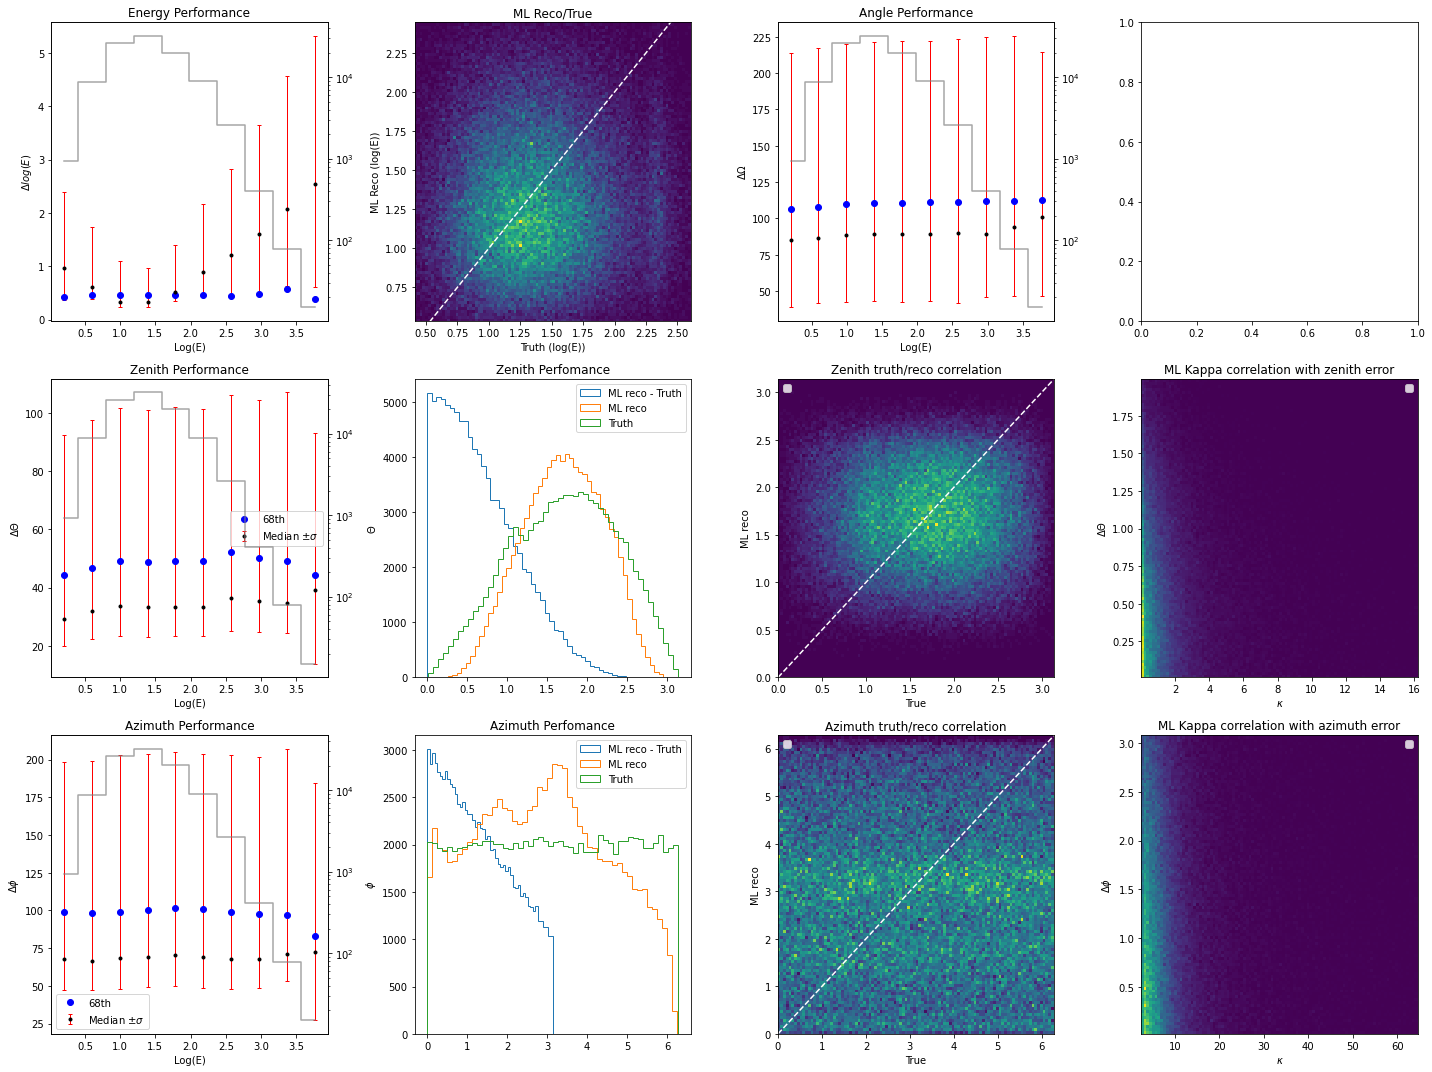

In [17]:
# os.chdir('../model_eval')
# os.getcwd()
import eval_plots as e
reload(e)
performance=e.performance_vM2D
# performance(reco1, true1);
performance(reco, true);

In [22]:
dataset[0].y, reco[0], true[0]

(array([1.83296885e+00, 1.54510326e+00, 2.56860902e+00, 7.60884500e+06]),
 array([1.746907 , 2.1157746, 0.5132514, 2.275828 , 9.4844885],
       dtype=float32),
 array([1.7583747e+00, 2.7659461e+00, 4.9387574e+00, 1.0305758e+07],
       dtype=float32))

In [32]:
loader = DisjointLoader(dataset[0,1], batch_size=batch_size, epochs=1)

In [33]:
next(loader)

((array([[ 0.03125   , -0.07293   , -0.44648001,  3.59550562,  0.41666669,
           1.        , -0.35000002],
         [ 0.03125   , -0.07293   , -0.45348999, -0.46067416,  0.66666667,
           0.        , -0.35000002],
         [ 0.03125   , -0.07293   , -0.45348999, -0.417603  , -0.66666672,
           0.        , -0.35000002],
         [ 0.07237   , -0.0666    , -0.34906   ,  2.97752809, -0.24999998,
           1.        ,  0.        ],
         [ 0.07237   , -0.0666    , -0.46820999,  0.17790262,  0.58333341,
           1.        , -0.35000002],
         [ 0.0572    , -0.10552   , -0.30857999,  1.90636704, -0.75000002,
           1.        ,  0.        ],
         [ 0.0572    , -0.10552   , -0.39969   ,  0.66479401,  0.08333336,
           1.        ,  0.        ],
         [ 0.0572    , -0.10552   , -0.42072   ,  0.12921348, -0.41666669,
           0.        ,  0.        ],
         [ 0.0572    , -0.10552   , -0.42773001, -0.07116105, -0.08333336,
           0.        ,  0.   

In [56]:
# os.chdir("../from_config") ######!!!!!!
import dev.data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=0.5e5, skip=int(2e6), n_neighbors=25, muon=False, database='dev_lvl7', restart=False, features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"], 
    targets= ["energy_log10", "zenith","azimuth", "event_no"],
    transform_path='../db_files/dev_lvl7/transformers.pkl',
    db_path= '../db_files/dev_lvl7/dev_lvl7_mu_nu_e_classification_v003.db')
loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)
import winsound
winsound.Beep(400,1)

Not notebook
Connecting to db-file
Loading Neutrinos
Reading files
Events read
Features read
Targets read, transforming
Splitting data to events
   event_no
0   3391500
1   3391500
2   3391500
3   3391500
4   3391500
     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0  0.19434 -0.03092 -0.34694  1.009363      1.166667    1.0 -0.35
1  0.03125 -0.07293 -0.32033  1.750936     -0.333333    1.0  0.00
2  0.04160  0.03549 -0.29807  0.187266     -1.000000    1.0  0.00
3  0.04160  0.03549 -0.31910  0.220974      0.250000    1.0  0.00
4  0.04160  0.03549 -0.31910  0.292135     -0.833333    1.0  0.00


  0%|▏                                                                            | 159/50000 [00:00<01:17, 643.58it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0  0.19434 -0.03092 -0.34694  1.009363      1.166667    1.0 -0.35
1  0.03125 -0.07293 -0.32033  1.750936     -0.333333    1.0  0.00
2  0.04160  0.03549 -0.29807  0.187266     -1.000000    1.0  0.00
3  0.04160  0.03549 -0.31910  0.220974      0.250000    1.0  0.00
4  0.04160  0.03549 -0.31910  0.292135     -0.833333    1.0  0.00
   energy_log10    zenith   azimuth  event_no  pid
0      1.216103  1.391962  1.105014   3391500   14
1      0.991771  0.443755  1.673268   3391501  -14
2      1.147159  0.158704  2.127800   3391502  -14
3      1.221494  1.732934  5.620712   3391503  -14
4      0.819114  1.386721  0.824010   3391504   14


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:25<00:00, 1955.50it/s]


List->array
Saving dataset
Loading data to memory


In [22]:
import pandas as pd
def get_event_no():
        print('Reading sets')
        sets = pd.read_pickle('../db_files/dev_lvl7/sets.pkl')
        train_events = sets['train']
        test_events = sets['test']
        return train_events['event_no'].to_numpy(), test_events['event_no'].to_numpy()

In [24]:
train_events, test_events=get_event_no()

Reading sets


In [25]:
@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets

In [ ]:
def predict(loader):
    prediction_list, target_list = [], []
    for batch in tqdm(loader, total=loader.steps_per_epoch):
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)

        prediction_list.append(predictions.numpy())
        target_list.append(targets.numpy())
        y_reco  = tf.concat(prediction_list, axis = 0).numpy()
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32).numpy()
    return y_reco, y_true

In [38]:
train_ids=[]
test_ids=[]
for i in tqdm(range(len(dataset))):
    if int(dataset[i].y[3]) in test_events:
        test_ids.append(i)
    else:
        train_ids.append(i)

In [51]:
dt_train=dataset[train_ids[:100000]]
dt_test=dataset[test_ids[:100000]]
len(test_ids)
# len(test_idx), len()

199933

In [52]:
loader_test = DisjointLoader(dt_test, batch_size=batch_size, epochs=1)
loader_train = DisjointLoader(dt_train, batch_size=batch_size, epochs=1)

In [46]:
reco, true=predict(loader_test)

In [53]:
reco1, true1=predict(loader_train)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


{'Old metrics:': ' ', 'E': 0.192, 'Omega': '49.401', 'Zeni': '19.268', 'Azi': '54.165'} {'E': '0.129, 0.038<->0.297', 'Omega': '33.450, 12.309<->73.885', 'Zeni': '11.972, 3.203<->29.946', 'Azi': '30.771, 7.330<->95.717'}


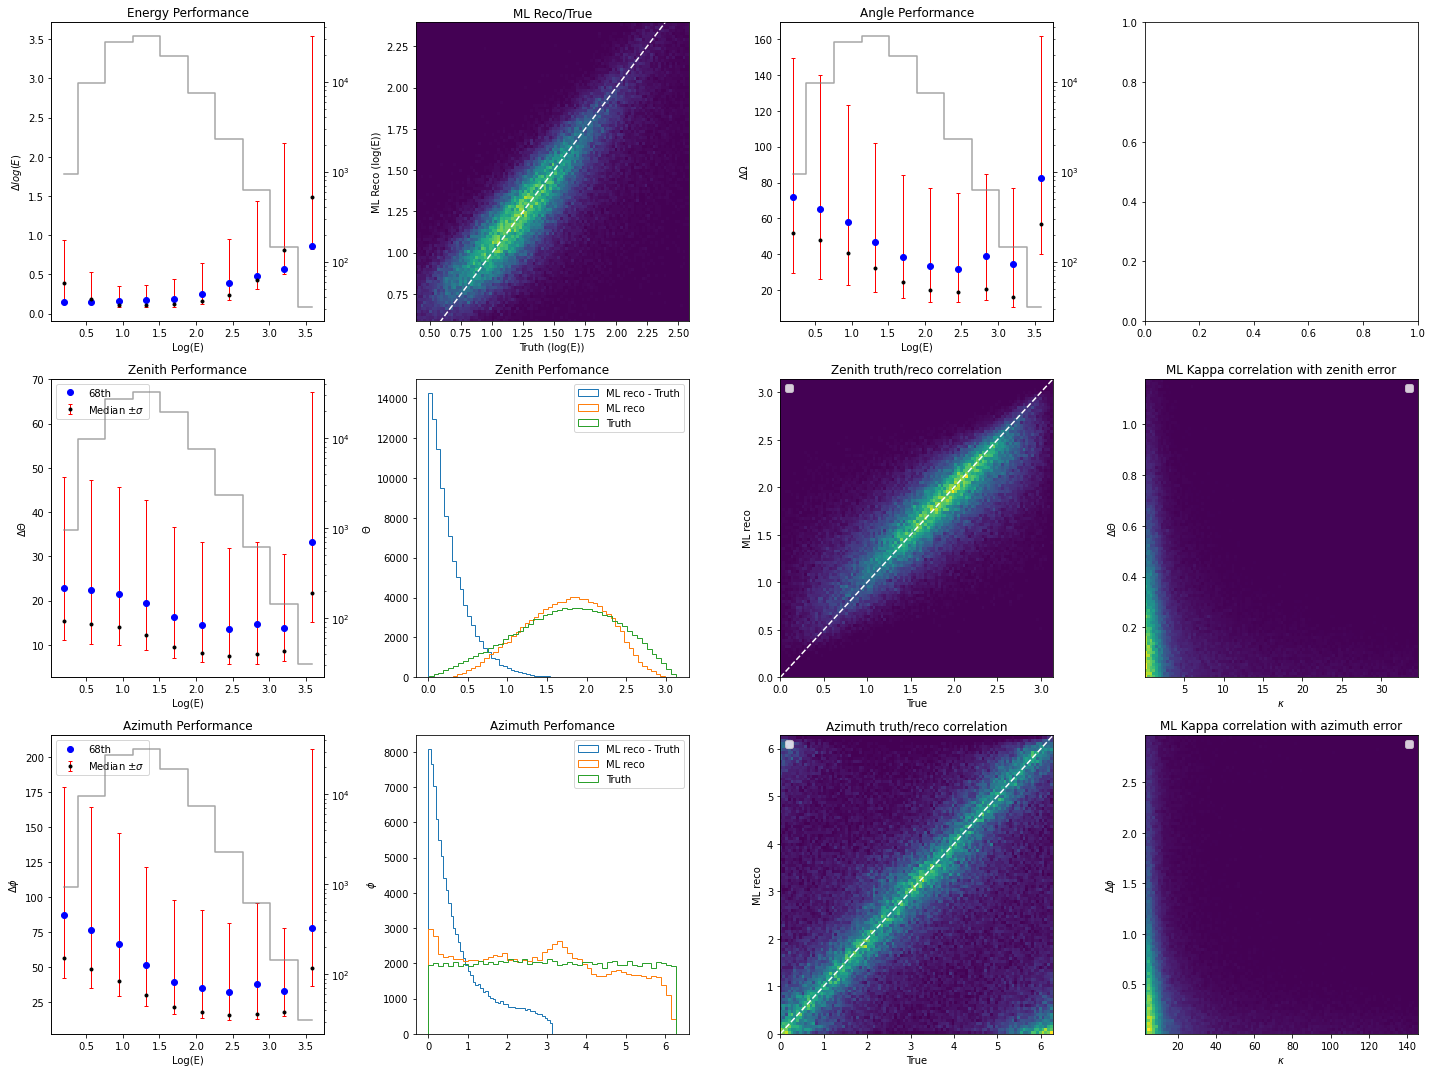

In [48]:
import eval_plots as e
reload(e)
performance=e.performance_vM2D
# performance(reco1, true1);
performance(reco, true);

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


{'Old metrics:': ' ', 'E': 0.193, 'Omega': '49.305', 'Zeni': '19.244', 'Azi': '54.564'} {'E': '0.129, 0.038<->0.298', 'Omega': '33.319, 12.422<->73.786', 'Zeni': '11.844, 3.148<->30.058', 'Azi': '30.700, 7.305<->96.653'}


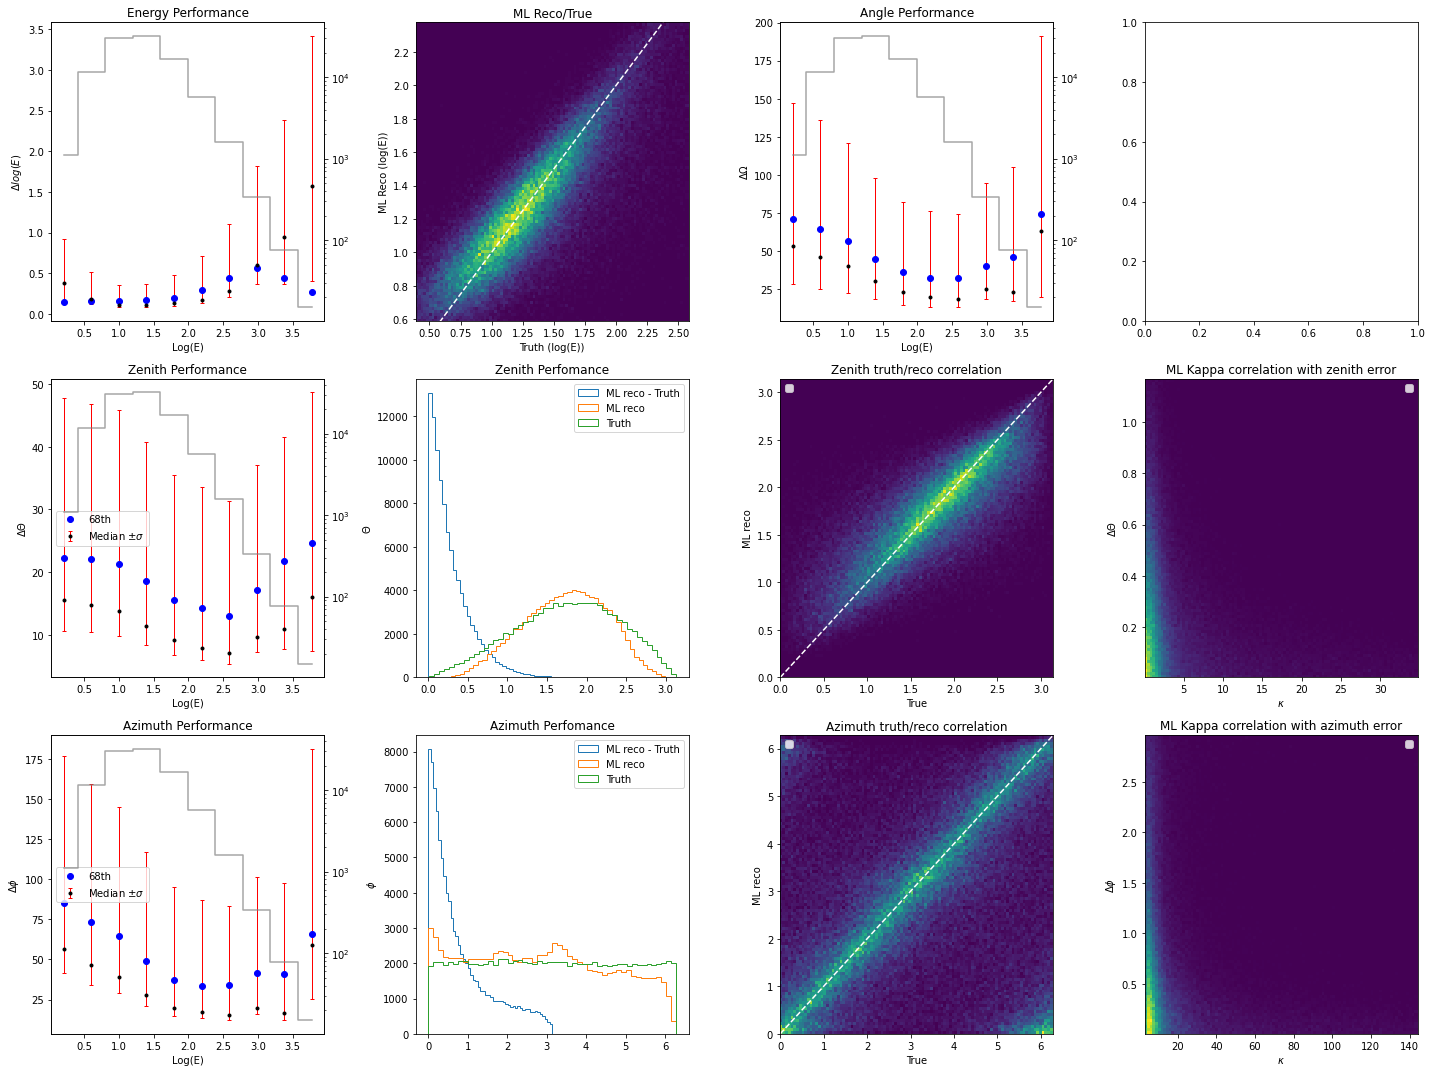

In [54]:
performance(reco1, true1);

In [68]:
import dev.alldata as dl
reload(dl)
graph_data=dl.graph_data

Not notebook


In [69]:
dataset=graph_data(restart=True)

Removed and ready to reload
Connecting to db-file
Reading files
Reading sets
Starting loop
Events read
Features read
Targets read, transforming
Splitting data to events


  0%|                                                                           | 23/829181 [00:00<1:00:14, 229.40it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0  0.07941 -0.24824 -0.31809  0.228464      0.166667    1.0 -0.35
1  0.03125 -0.07293 -0.35537 -0.503745      0.000000    0.0  0.00
2  0.03125 -0.07293 -0.36939 -0.415730      1.000000    0.0 -0.35
3  0.03125 -0.07293 -0.37640 -0.406367      1.000000    0.0  0.00
4  0.05720 -0.10552 -0.28756  1.425094      0.083333    1.0  0.00
   energy_log10    zenith   azimuth  event_no
0      0.526180  2.654448  0.190388         0
1      0.421948  2.676098  1.044445         1
2      0.650951  2.769452  3.474142         2
3      0.474153  1.986612  3.843793         3
4      0.620465  2.613257  4.754485         4


100%|████████████████████████████████████████████████████████████████████████| 829181/829181 [10:55<00:00, 1265.76it/s]


List->array
Saving dataset
Events read
Features read
Targets read, transforming
Splitting data to events


  0%|                                                                             | 4/829181 [00:00<7:41:37, 29.94it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0 -0.03296  0.06244 -0.42331  0.691011      0.083333    1.0 -0.35
1  0.03125 -0.07293 -0.35537  2.419476      0.166667    1.0  0.00
2  0.07237 -0.06660 -0.45419  0.443820     -0.416667    1.0 -0.35
3  0.04160  0.03549 -0.37517  1.762172     -0.166667    1.0  0.00
4  0.04160  0.03549 -0.43123 -0.003745      0.166667    1.0  0.00
   energy_log10    zenith   azimuth  event_no
0      1.102126  2.356131  2.195950    829181
1      0.786543  1.168745  0.805354    829182
2      0.756740  1.859801  4.897820    829183
3      1.812697  2.022997  2.989641    829184
4      1.886296  2.300012  2.758065    829185


100%|████████████████████████████████████████████████████████████████████████| 829181/829181 [05:58<00:00, 2313.79it/s]


List->array
Saving dataset
Events read
Features read
Targets read, transforming
Splitting data to events


  0%|                                                                           | 12/829181 [00:00<2:16:50, 100.99it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0  0.00171 -0.15063 -0.33676  4.069288      0.333333    1.0 -0.35
1  0.12497 -0.13125 -0.27228  3.340824      0.500000    1.0 -0.35
2  0.04629 -0.03488 -0.28198  2.700375      0.833333    1.0 -0.35
3  0.04629 -0.03488 -0.33304 -0.385768      0.750000    0.0  0.00
4  0.04629 -0.03488 -0.35006 -0.518727     -0.500000    0.0  0.00
   energy_log10    zenith   azimuth  event_no
0      1.140948  2.233440  4.466167   3049862
1      1.177141  0.913655  4.725401   3049863
2      0.761362  1.888707  3.717148   3049864
3      1.160256  2.063478  3.362123   3049865
4      1.069403  1.763828  3.104656   3049866


100%|████████████████████████████████████████████████████████████████████████| 829181/829181 [05:40<00:00, 2437.17it/s]


List->array
Saving dataset
Events read
Features read
Targets read, transforming
Splitting data to events


  0%|                                                                           | 176/829181 [00:00<07:53, 1751.66it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0  0.03125 -0.07293 -0.33434  0.106742      1.500000    1.0  0.00
1  0.07237 -0.06660 -0.22992  0.664794     -0.166667    1.0 -0.35
2  0.07237 -0.06660 -0.38410  1.093633     -0.500000    1.0  0.00
3  0.11319 -0.06047 -0.34332 -0.337079      0.500000    0.0  0.00
4  0.11319 -0.06047 -0.35734 -0.496255     -0.083333    0.0  0.00
   energy_log10    zenith   azimuth  event_no
0      0.595136  1.256344  5.766563   3879043
1      0.323245  2.104637  4.645538   3879044
2      0.408126  1.394343  3.175933   3879045
3      0.547930  0.245655  3.305804   3879046
4      0.490812  2.412638  0.410970   3879047


100%|████████████████████████████████████████████████████████████████████████| 829181/829181 [05:45<00:00, 2402.96it/s]


List->array
Saving dataset
Events read
Features read
Targets read, transforming
Splitting data to events


  0%|                                                                                       | 0/829180 [00:00<?, ?it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0  0.03125 -0.07293 -0.25024 -0.063670     -0.833333    1.0 -0.35
1  0.07237 -0.06660 -0.18786 -0.001873     -0.250000    1.0 -0.35
2  0.07237 -0.06660 -0.21590 -0.020599      0.666667    1.0 -0.35
3  0.05720 -0.10552 -0.22448 -0.404494      0.500000    0.0  0.00
4  0.05720 -0.10552 -0.22448 -0.340824     -0.416667    0.0  0.00
   energy_log10    zenith   azimuth  event_no
0      0.882667  2.073885  5.790948   6101874
1      1.017406  1.477141  3.570663   6101875
2      1.180446  2.352314  0.915746   6101876
3      1.149058  1.232879  1.631399   6101877
4      1.211356  1.961395  4.909856   6101878


100%|████████████████████████████████████████████████████████████████████████| 829180/829180 [05:44<00:00, 2409.92it/s]


List->array
Saving dataset
Events read
Features read
Targets read, transforming
Splitting data to events


  0%|                                                                             | 4/829180 [00:00<5:48:03, 39.71it/s]

     dom_x    dom_y    dom_z  dom_time  charge_log10  width   rqe
0 -0.12177 -0.17103 -0.39958  1.205993      0.416667    1.0 -0.35
1  0.04629 -0.03488 -0.40113  0.091760      0.916667    1.0  0.00
2 -0.03296  0.06244 -0.47437 -0.288390      0.750000    1.0 -0.35
3  0.09049  0.08235 -0.36639  0.691011     -0.583333    1.0 -0.35
4  0.09049  0.08235 -0.38341  0.402622      0.250000    1.0 -0.35
   energy_log10    zenith   azimuth  event_no
0      1.958721  1.113272  1.737320   6931054
1      2.295080  2.154183  3.045124   6931055
2      2.156738  0.671283  2.539080   6931056
3      1.951896  2.606658  2.595839   6931057
4      1.912786  0.970871  3.896613   6931058


100%|████████████████████████████████████████████████████████████████████████| 829180/829180 [05:43<00:00, 2413.78it/s]


List->array
Saving dataset


OSError: [Errno 28] No space left on device

In [ ]:
dataset=graph_data(restart=True, n_steps=3)

Connecting to db-file
Reading files
Reading sets
